# Imports

In [1]:
from src.datasets import TabTrainDataset
from torch.utils.data import DataLoader
from src.model import NotationModel, ModelConfig
from torchvision.transforms import InterpolationMode
from pathlib import Path

import torchvision.transforms as transforms
import pytorch_lightning as pl
import torch

### Hyperparameters

In [2]:
BATCH_SIZE = 16
FEATURE_NUM = 2**9
IN_CHANNELS = 2**6
NUM_HEADS = 6
IM_RES = 256
AVG_POOL_DIM = 8
EPOCH_NUM = 20
LR = 1e-4
NUM_WORKERS = 4
NUM_CLASSES = 7

### Dataset

In [3]:
transform = transforms.Compose([
    transforms.Resize((IM_RES, IM_RES), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# augmentations = transforms.Compose([
#     transforms.RandomAffine(degrees=0, translate=(0.04, 0.04))
# ])

In [4]:
from src.util import split_dataset

basepath = Path().resolve().parent.parent
labeled_tabs_path = basepath / "data" / "labelled_tabs.csv"
image_path = basepath / "data" / "dataset" / "tabs"

dataset = TabTrainDataset(labeled_tabs_path, image_path, transform, use_finger_labels=False)
train_set, val_set = split_dataset(dataset, train_ratio=0.9)

kwargs = {
    "num_workers": NUM_WORKERS,
    "batch_size": BATCH_SIZE,
    "pin_memory": True,
}

train_loader = DataLoader(train_set, shuffle=True, **kwargs)
val_loader = DataLoader(val_set, shuffle=False, **kwargs)

Train set size: 100
Val set size: 12


Image shape: torch.Size([1, 256, 256])


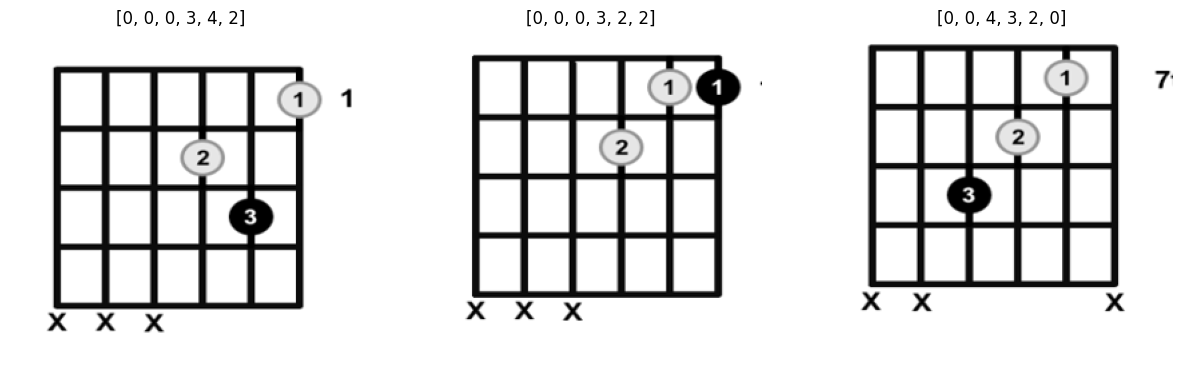

In [5]:
from src.util import montage

montage(train_set, 3)
print(f"Image shape: {train_set[0][0].shape}")

### Trainer Setup

In [6]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",
    save_top_k=1,
    mode="min",
    dirpath="model_checkpoints",
    filename="model-{epoch:02d}-{val_loss:.2f}"
)

trainer_config = {
    "log_every_n_steps": 3,
    "enable_model_summary": True,
    "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
    # "profiler": "simple",
    "enable_checkpointing": False, 
    # "callbacks": [checkpoint_callback],
    "logger": False
}

trainer = pl.Trainer(max_epochs=EPOCH_NUM, **trainer_config)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Tab Prediction

In [7]:
model_config = ModelConfig(num_classes=NUM_CLASSES,
                           feature_num=FEATURE_NUM,
                           im_res=IM_RES,
                           num_heads=NUM_HEADS,
                           in_channels=IN_CHANNELS,
                           avg_pool_dim=AVG_POOL_DIM,
                           learning_rate=LR)
model = NotationModel(model_config)

In [8]:
trainer.fit(model, train_loader, val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type       | Params | Mode 
------------------------------------------------------------
0 | encoder              | Sequential | 11.0 M | train
1 | classification_heads | ModuleList | 1.4 M  | train
------------------------------------------------------------
12.4 M    Trainable params
0         Non-trainable params
12.4 M    Total params
49.479    Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


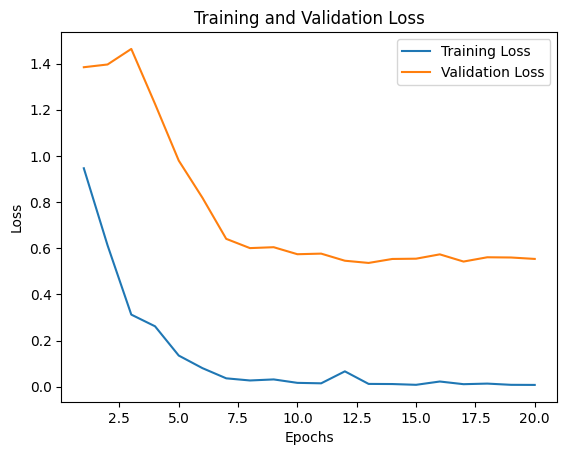

Training loss: 0.0076612
Validation loss: 0.5536736


In [9]:
from src.util import show_loss_info

tab_train_losses = model.train_losses
tab_val_losses = model.val_losses[1:] # PyTorch Lightning performs 1 validation step before training starts
show_loss_info(tab_train_losses, tab_val_losses)